# House Sales in King County, USA - Price Prediction
&nbsp;
### Welcome to my notebook!
&nbsp;

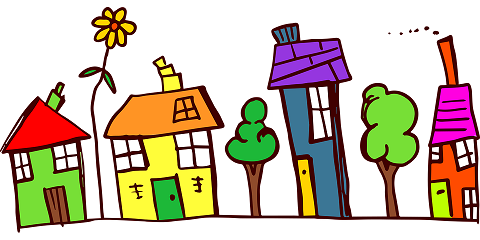

I created this notebook to practice and better understand the typical workflow of a data science project. 

The notebook contains the following components:
1. Data Cleaning
2. EDA & Data Visualization
3. Model Building (Comparing 10 different regression models)

Being new to the DS field, I find that working on different datasets is the best way to improve my skills.

The notebook should be fairly easy to follow along as I tried documenting my logic every step of the way. 

**Any comments, suggestions, and/or feedback is greatly appreciated!**

## Overview

### 1. [Importing Libraries](#1)
### 2. [Data Cleaning](#2) 
### 3. [Visualization and EDA](#3) 
### 4. [Model Building](#4)
### 5. [Summary](#5)


# **Importing** <a id="1"></a>

In [ ]:
# Standard data analysis and wrangling libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Various ML models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Cross Validation
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

# Maps for Visualization
import folium

# Formatting
pd.set_option('display.max_columns', None) # Show all column names. For example when running the df.head() method. 

# Warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
# Import data

df = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')

In [ ]:
df.head()

Initial thoughts on the data

- Date should be converted to datetime format
- Eliminate 'T000000' from every row in the date column
- Convert price column to integers
- What's the difference between sqft_living/sqft_lot and sqft_living15/sqft_lot15? (Screenshot below explains this)

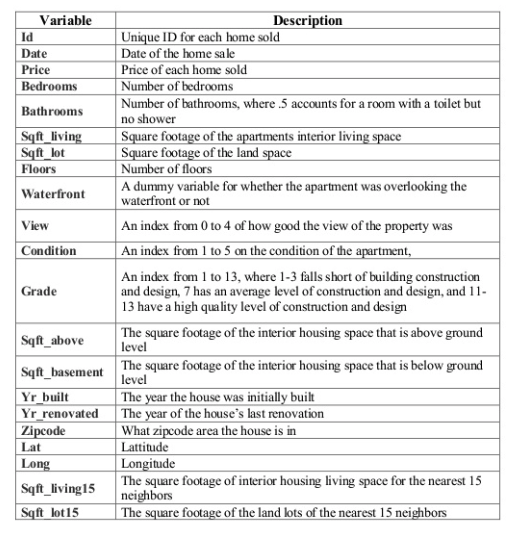

In [ ]:
df.info()

# **Data Cleaning** <a id="2"></a>

Based on the above cell, it appears that there is no missing data. There are 21613 rows in the dataset.

Prepare data for EDA:

- convert each column to the correct format
- search for and remove outliers

### Date - Column

- Remove the 'T000000' from the date column and convert to datetime format.

In [ ]:
# Change date to datetime format

clean_date = df.date.apply(lambda x: x.split('T')[0])
clean_date

In [ ]:
# Replace date column with the 'clean_date' variable

df['date'] = clean_date
df.head()

In [ ]:
# Convert date column to Pandas datetime format

df['date'] = pd.to_datetime(df['date'], format = '%Y/%m/%d')

df.head()

### Price column - convert to integers

- Prices should be integers, not floats. Pennies are irreleveant when dealing with high prices. 

In [ ]:
df.price = df.price.astype(np.int64)

In [ ]:
# Confirm price column was converted to type int

df.info()

In [ ]:
df.head()

## Check for outliers

- Create simple scatterplots and remove outliers. 

In [ ]:
df.columns

In [ ]:
# Select columns to plot

cols_to_plot = df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]

In [ ]:
# Function to plot scatterplots

def plot_scatterplots():
    for i in cols_to_plot.columns:
        cat_num = cols_to_plot[i].value_counts()
        print('Graph for {}: Total = {}'.format(i.capitalize(), len(cat_num)))
        sns.scatterplot(x=cat_num.index, y=cat_num)
        plt.xticks(rotation=90)
        plt.show()
        
plot_scatterplots()

Initial thoughts on graphs above. 

1. Price - Remove houses over 6mil - possibly even houses over 4mil?
2. Bedrooms - Remove over 30 bedrooms?
3. Bathroom - 0? Look into this. How can a house not have any bathrooms? 
4. Sqft_living - Possily remove houses that are over 12,000sqft?
5. sqft_lot - Remove anything over 750,000sqft?
6. sqft_above - Possibly remove listings that are over 8000sqft? Maybe even over 6500sqft - depending on the number of listings.
7. sqft_basement - Drop listings that are over 3000sqft?
8. sqft_lot15 - Drop listings that are over 500,000sqft?

### Price - outliers

In [ ]:
# Over 6mil - Only 3 listings, let's see how many houses cost more than 4mil.

df.loc[df.price > 6000000]

In [ ]:
# Only 11 homes over $4mil.
# I think we can safely drop these. 

print(len(df.loc[df.price > 4000000]))
df.loc[df.price > 4000000]

In [ ]:
# Drop homes over $4mil

df = df[df.price < 4000000]
df

### Bedrooms - outliers

In [ ]:
# 11 and 33 bedroom homes are clearly anomalies as they only have 1 listing each. 10 bedroom homes are also very rare with 3 listings. 
# I'll remove all homes with 10, 11, and 33 bedrooms. 

df.bedrooms.value_counts()

In [ ]:
# Drop 10, 11, and 33 bedroom homes

df = df[df.bedrooms < 10]

In [ ]:
# Let's examine homes with 0 bedrooms.

# A house with 0 bedrooms doesn't make sense to me. There are houses with 0 bedrooms and 0 bathrooms but have huge lots? 
# Are these possibly offices? Was the data not entered correctly?
# I'm going to drop all of these rows because I think we'll come up with more accurate models this way. 

df[df.bedrooms == 0]

In [ ]:
# Drop houses with 0 bedrooms

df = df[df.bedrooms > 0]

### Bathrooms - outliers

In [ ]:
df.bathrooms.value_counts()

In [ ]:
# A house with no bathrooms? Again, is this possibly some sort of store/office? Still seems strange if that's the case. 
# I'm going to drop the 3 rows.

df[df.bathrooms == 0]

In [ ]:
df = df[df.bathrooms > 0]

In [ ]:
df.bathrooms.value_counts()

In [ ]:
# I'm going to drop houses that have between 1-3 value counts (number of bathrooms from above) as I think this will lead to more accurate results.

df = df[df.bathrooms != 6.75]
df = df[df.bathrooms != 7.50]
df = df[df.bathrooms != 8.00]
df = df[df.bathrooms != 6.50]
df = df[df.bathrooms != 6.25]

In [ ]:
# Looks better now.  

df.bathrooms.value_counts()

### Sqft_living - outliers

In [ ]:
# These rows were dropped in one of the previous steps while removing outliers. 

df[df.sqft_living > 12000]

### Sqft lot - outliers

In [ ]:
df.sqft_lot.value_counts()

In [ ]:
print(len(df[df.sqft_lot > 750000]))
df[df.sqft_lot > 750000]

In [ ]:
# Let's drop the 11 rows of homes that have a lot of over 7500000 as they seem like outliers.

df = df[df.sqft_lot < 750000]

### Sqft above - outliers

- Maybe remove listings that are over 8000sqft? Possibly even over 6500 - depending on the number of listings.

In [ ]:
# Seems like these were already dropped, let's check over 6500 sqft. 

df[df['sqft_above'] > 8000]

In [ ]:
# Only 6 entries. Let's drop these too. 

df[df.sqft_above > 6500]

In [ ]:
df = df[df.sqft_above < 6500]

### Sqft basement - outliers

sqft_basement - Drop listings that are over 3000sqft?

In [ ]:
df[df.sqft_basement > 3000]

In [ ]:
# Let's drop the 2 outliers

df = df[df.sqft_basement < 3000]

### Sqft lot15 - outliers

sqft_lot15 - Drop listings that are over 500,000 sqft?

In [ ]:
df[df.sqft_lot15 > 500000]

In [ ]:
# Drop the 1 row

df = df[df.sqft_lot15 < 500000]

## Ensure all outliers have been dropped

In [ ]:
cols_to_plot = df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]


plot_scatterplots()

&nbsp;

Looks better now with the clearest outliers removed. 

I believe that more outliers exist within the dataset, however removing too many rows could lead to having a model that overfits the data.

Move on to Visualization and EDA.

&nbsp;

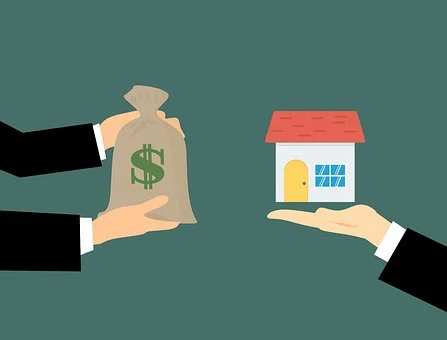

&nbsp;

# **Visualization and EDA** <a id="3"></a>

&nbsp;

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.describe()

Brief inferences from the data:

- The average house from the dataset has at least 3 bedrooms and 2 bathrooms
- Average size is about 2100 sqft. 
- Very few waterfront properties
- The average house was built in 1970

### House Price Distribution

In [ ]:
plt.figure(figsize=(10,4))
plt.title("House Price Distribution", size=18)
sns.distplot(df["price"])

plt.xlabel('Average house price', size=15)
plt.show()

- The prices are  slightly skewed to the right.
- May need to normalize the data.

### House Prices and Waterfront Property

In [ ]:
sns.boxplot(x = df['waterfront'], y=df['price'], palette="Accent")
plt.suptitle('House Prices and Waterfront Property', size=18)
plt.xlabel('Waterfront (1 = Yes)', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)

plt.show()

- Waterfront properties are all  distributed within a specific range, without outliers.
- Non-waterfront properties vary widely in price and thus have a large number of outliers.
- As expected, waterfront properties are on average more expensive than regular homes - the mean price is $1,000,000 greater.

### House Prices and Number of Floors

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x = df['floors'], y=df['price'], palette="Set2")
plt.suptitle('House Prices and Number of Floors', size=18)
plt.xlabel('Number of floors', fontsize = 15)
plt.ylabel('House Prices', fontsize =15)

plt.show()

- Lots of outliers for houses that have between 1-3 floors.
- Houses with 3.5 floors seem to have the smallest price fluctuations, although there are only 7 such properties in the dataset - insuficient for any accurate deduction. 
- There seems to be an uptrend in price as the number of floors increases, though decreases at 3 and 3.5 floors - I wonder why that is. Are houses that have 3 and 3.5 floors older? Let's run a comparison.

In [ ]:
df.floors.value_counts()

In [ ]:
# Create a pivot table with floors/yr_built 

pd.pivot_table(df, index='floors', values = 'yr_built').astype(int)

My hopothesis was incorrect. In a way, it's actually the opposite of what I predicted. Houses with 3 floors are on average newer compared to homes with any other number of floors. Let's explore other features. 

### House Prices and Number of Bathrooms

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df['bathrooms'], y=df['price'], palette="Set3_r")
plt.suptitle('House Prices and Number of Bathrooms', size=18)
plt.xlabel('Number of Bathrooms', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)
plt.xticks(rotation=90)

plt.show()

- There seems to be a general uptrend/linear relationship in price with the increase in the number of bathrooms
- Lots of outliers exist in the data
- As the number approaches 5 bathrooms the price begins to fluctuate significantly. This is mainly due to having a limited number of houses that have that many bathrooms within the dataset. 

### House Prices and Grade Rating

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x = df['grade'], y=df['price'], palette="PiYG")
plt.suptitle('House Prices and Grade Rating', size=18)
plt.xlabel('Grade', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)

plt.show()

Description of Grade Rating:

**"An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design."**

- Many outliers in the data.
- Appears to be a quadratic relationship between Grade and Price. 
- Significant increase in the price range as the grade increases.

In [ ]:
df.grade.value_counts()

In [ ]:
df.head()

### Price difference between the most/least expensive homes

How does the zipcode impact the price of a home?

In [ ]:
# Create a dataframe for the top 5/bottom 5 zipcodes in terms of average price. Then, combine the dataframes. 

pd.options.display.float_format = "{:.2f}".format # Round to 2 decimal places

top = df.groupby('zipcode')['price'].mean().reset_index().sort_values('price', ascending=False)[:5]
bot = df.groupby('zipcode')['price'].mean().reset_index().sort_values('price', ascending=False)[-5:]
combined = pd.concat([top, bot])
combined.sort_values('price', ascending=True, inplace=True)

In [ ]:
plt.figure(figsize=(6,8))

sns.barplot(x='price', y='zipcode' , order = combined['zipcode'], orient='h', data=combined, palette='YlOrRd')

plt.title('Neighborhood Price Comparison', size=18)
plt.ylabel('Zipcode', size=15)
plt.xlabel('Average Home Price', size=15)
plt.xticks(rotation=45)

plt.show()

- There is a large price gap between the bottom/top 5 neighbourhoods. 
- Average price of a house in the bottom 5 is less than 250,000 whereas the top 5 seem to start at almost 1,000,000.
- Let's map this to see the difference in location.

### Top 5/Bottom 5 Zipcode Price Comparison

In [ ]:
# Convert zipcode to string type because the Folium Choropleth "columns" parameter only accepts strings

combined['zipcode'] = combined['zipcode'].astype(str)

In [ ]:
# Create a map with folium using the combined variable from above

my_map = folium.Map(width=500, height=400,location=[47.45,-122.22], zoom_start=9.3)

folium.Choropleth(
    geo_data="/kaggle/input/wa-json-file/wa_washington_zip_codes_geo.min.json",
    data=combined,
    columns=['zipcode', 'price'], 
    key_on='feature.properties.ZCTA5CE10', 
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    nan_fill_color='clear', 
    nan_fill_opacity=0.1,
    legend_name='HOUSE PRICE'
).add_to(my_map)

folium.LayerControl().add_to(my_map)

my_map

- Expensive neighborhoods are clustered together.
- The most expensive neighborhood is located in close proximity to Lake Washington. How many waterfront homes from the dataset are located here?

In [ ]:
# 157 waterfront homes in the dataset

df.waterfront.value_counts()

In [ ]:
# Only 1 waterfront property is located in the most expensive zipcode. I assumed that there would be a lot more. 

df[(df['zipcode'] == 98039) & (df['waterfront'] == 1)]

In [ ]:
top_5_zipcodes = (98039, 98004, 98040, 98112, 98109)

In [ ]:
# How many waterfront homes are located in the top 5 zip codes? 

print(top)
print('')
df[(df['zipcode'].isin(top_5_zipcodes)) & (df['waterfront'] == 1)]

- Only 11 out of the 157 waterfront homes in the dataset are located in the top 5 expensive zipcodes. 
- My assumption was that there would be a lot more waterfront homes in the 5 most expensive neighborhoods. 

### General Zipcode Price Comparison

In [ ]:
# Let's visualize the price distirubtion for all zipcodes on a map. 

zipcode_prices = df.groupby('zipcode')['price'].mean().reset_index().sort_values('price', ascending=False)
zipcode_prices['zipcode'] = zipcode_prices['zipcode'].astype(str)
zipcode_prices

In [ ]:
# Create a map with folium using data from the zipcode_prices variable created above.

my_map1 = folium.Map(width=500, height=400,location=[47.40,-122.02], zoom_start=8.4)

folium.Choropleth(
    geo_data="/kaggle/input/wa-json-file/wa_washington_zip_codes_geo.min.json",
    data=zipcode_prices,
    columns=['zipcode', 'price'], 
    key_on='feature.properties.ZCTA5CE10', 
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.4,
    nan_fill_color='clear', 
    nan_fill_opacity=0.2,
    legend_name='HOUSE PRICE'
).add_to(my_map1)

folium.LayerControl().add_to(my_map1)

my_map1

### House Price and Size Comparison

In [ ]:
sns.lmplot(x='sqft_living', y='price', data=df, scatter_kws={'s':8}, hue='waterfront', height=6)

plt.title('Size Relative to Price', size=18)
plt.ylabel('House Price', size=15)
plt.xlabel('Total Square Feet', size=15)


plt.show()

- The baseline price for waterfront properties is higher on average than those without a waterfront.
- As the house size increases, the price gap significantly widens between waterfront/non waterfront houses.

### Year Built and Price

- Does the year built notably impact the price? Are newer homes more expensive? 

In [ ]:
# 116 different years within the dataset

df.yr_built.nunique()

In [ ]:
# 0 null values

df.yr_built.isnull().sum()

In [ ]:
# Check the oldest/newest year built

print(df.yr_built.min())
print(df.yr_built.max())

In [ ]:
plt.figure(figsize=(16,5))

sns.lineplot(x='yr_built', y='price', data=df,linewidth=1.5, color='blueviolet', ci=None)

plt.title('Average Home Price and Year Built', size=18)
plt.ylabel('Average Price', size=15)
plt.xlabel('Year', size=15)

plt.show()

- Houses built before 1940 and after 2000 have a higher average price.
- Houses approximately between 1945 - 1980 cost less on average.
- Is this possibly due to most very old houses (before 1940) having been renovated?

### Correlation Between Variables

In [ ]:
# let's graph the below

df.corr()

In [ ]:
df.columns.tolist()

In [ ]:
# Let's put price as the last column for an easier interpretation of the correlation heatmap below.

cols = ['id',
 'date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'price',]

In [ ]:
df = df[cols]

In [ ]:
corr = df.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap='YlOrBr', annot=True)

plt.show()

- Sqft_living (total square feet of the house, not including the lot) and Grade have robust correlations to price, similar to what we saw on the graphs earlier.
- ID and zipcode have weak negative correalations.
- I was expecting a strong positive correlation between sqft_lot and yr_built with price. Though it seems that other variables have a stronger relationship to price. 

In [ ]:
# Sort the highest/lowest correlated variables

high_corr = df.corr()['price'].sort_values(ascending=False)
high_corr

# **Model Building** <a id="4"></a>

The following models will be compared:
- Multi Linear Regression Model
- Lasso Linear Regression Model
- Random Forest Regression Model
- XGBoost Regression Model
- ExtraTreesRegressor Model
- Decision Tree Regressor Model
- Gradient Boosting Regressor Model
- Elastic Net Regressor Model
- Neural Network Regression Model
- Ada Boost Regressor Model

In [ ]:
# Drop the price column and variables with low correlations

pd.options.display.float_format = "{:.4f}".format # Lets show the results with 4 decimal places

dropped_vars = ['price','id', 'date','long']

X = df.drop(dropped_vars, axis='columns')
y = df['price']

In [ ]:
# Split up the training/testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### MULTI - LINEAR REGRESSION MODEL

In [ ]:
model_MLR = LinearRegression()
model_MLR.fit(X_train, y_train)

In [ ]:
yhat_pred_MLR = model_MLR.predict(X_test)

In [ ]:
cross_val_MLR = round(np.mean(cross_val_score(model_MLR,X_train,y_train)),4)
R2_MLR = round(r2_score(y_test, yhat_pred_MLR),4)
MAE_MLR = int(mean_absolute_error(y_test,yhat_pred_MLR))

### LASSO - LINEAR REGRESSION MODEL

In [ ]:
model_LLR = Lasso()
model_LLR.fit(X_train, y_train)

In [ ]:
yhat_pred_LLR = model_LLR.predict(X_test)

In [ ]:
cross_val_LLR = round(np.mean(cross_val_score(model_LLR,X_train,y_train)),4)
R2_LLR = round(r2_score(y_test, yhat_pred_LLR),4)
MAE_LLR = int(mean_absolute_error(y_test,yhat_pred_LLR))

### RANDOM FOREST REGRESSOR MODEL


In [ ]:
model_RFR = RandomForestRegressor(n_estimators=100)
model_RFR.fit(X_train, y_train)

In [ ]:
yhat_pred_RFR = model_RFR.predict(X_test)

In [ ]:
cross_val_RFR = round(np.mean(cross_val_score(model_RFR,X_train,y_train)),4)
R2_RFR = round(r2_score(y_test, yhat_pred_RFR),4)
MAE_RFR = int(mean_absolute_error(y_test,yhat_pred_RFR))

### XGBOOST REGRESSOR MODEL

In [ ]:
model_xgboost = XGBRegressor()
model_xgboost.fit(X_train, y_train)

In [ ]:
yhat_pred_xgboost = model_xgboost.predict(X_test)

In [ ]:
cross_val_xgboost = round(np.mean(cross_val_score(model_xgboost,X_train,y_train)),4)
R2_xgboost = round(r2_score(y_test, yhat_pred_xgboost),4)
MAE_xgboost = int(mean_absolute_error(y_test,yhat_pred_xgboost))

### ExtraTreesRegressor MODEL

In [ ]:
model_ETR = ExtraTreesRegressor()
model_ETR.fit(X_train, y_train)

In [ ]:
yhat_pred_ETR = model_ETR.predict(X_test)

In [ ]:
cross_val_ETR = round(np.mean(cross_val_score(model_ETR,X_train,y_train)),4)
R2_ETR = round(r2_score(y_test, yhat_pred_ETR),4)
MAE_ETR = int(mean_absolute_error(y_test,yhat_pred_ETR))

### DECISION TREE REGRESSOR MODEL

In [ ]:
model_DTR = DecisionTreeRegressor()
model_DTR.fit(X_train, y_train)

In [ ]:
yhat_pred_DTR = model_DTR.predict(X_test)

In [ ]:
cross_val_DTR = round(np.mean(cross_val_score(model_DTR,X_train,y_train)),4)
R2_DTR = round(r2_score(y_test, yhat_pred_DTR),4)
MAE_DTR = int(mean_absolute_error(y_test,yhat_pred_DTR))

### GRADIENT BOOSTING REGRESSOR MODEL

In [ ]:
model_GBR = GradientBoostingRegressor()
model_GBR.fit(X_train, y_train)

In [ ]:
yhat_pred_GBR = model_GBR.predict(X_test)

In [ ]:
cross_val_GBR = round(np.mean(cross_val_score(model_GBR,X_train,y_train)),4)
R2_GBR = round(r2_score(y_test, yhat_pred_GBR),4)
MAE_GBR = int(mean_absolute_error(y_test,yhat_pred_GBR))

### ELASTIC NET REGRESSOR MODEL

In [ ]:
model_ENR = ElasticNet()
model_ENR.fit(X_train, y_train)

In [ ]:
yhat_pred_ENR = model_ENR.predict(X_test)

In [ ]:
cross_val_ENR = round(np.mean(cross_val_score(model_ENR,X_train,y_train)),4)
R2_ENR = round(r2_score(y_test, yhat_pred_ENR),4)
MAE_ENR = int(mean_absolute_error(y_test,yhat_pred_ENR))

### MULTI-LAYER PERCEPTRON REGRESSOR MODEL

In [ ]:
model_MLP = MLPRegressor()
model_MLP.fit(X_train, y_train)

In [ ]:
yhat_pred_MLP = model_MLP.predict(X_test)

In [ ]:
cross_val_MLP = round(np.mean(cross_val_score(model_MLP,X_train,y_train)),4)
R2_MLP = round(r2_score(y_test, yhat_pred_MLP),4)
MAE_MLP = int(mean_absolute_error(y_test,yhat_pred_MLP))

### ADA BOOST REGRESSOR - MODEL

In [ ]:
model_ABR = AdaBoostRegressor()
model_ABR.fit(X_train, y_train)

In [ ]:
yhat_pred_ABR = model_ABR.predict(X_test)

In [ ]:
cross_val_ABR = round(np.mean(cross_val_score(model_ABR,X_train,y_train)),4)
R2_ABR = round(r2_score(y_test, yhat_pred_ABR),4)
MAE_ABR = int(mean_absolute_error(y_test,yhat_pred_ABR))

In [ ]:
models = pd.DataFrame({
    'Model': ['Multi Linear Regression', 'Lasso Linear Regression', 'Random Forest Regression', 
              'XGBOOST Regression', 'ExtraTreesRegressor', 'Decision Tree Regressor', 
              'Gradient Boosting Regressor', 'Elastic Net Regressor', 
              'Neural Network Regression','Ada Boost Regressor'],
    'Mean Absolute Error': [MAE_MLR, MAE_LLR, MAE_RFR, 
              MAE_xgboost, MAE_ETR, MAE_DTR, 
              MAE_GBR, MAE_ENR, MAE_MLP, MAE_ABR],    
    'R2 Score': [R2_MLR, R2_LLR, R2_RFR, 
              R2_xgboost, R2_ETR, R2_DTR, 
              R2_GBR, R2_ENR, R2_MLP, R2_ABR],    
    'Cross Validation Score': [cross_val_MLR, cross_val_LLR, cross_val_RFR, 
              cross_val_xgboost, cross_val_ETR, cross_val_DTR, 
              cross_val_GBR, cross_val_ENR, cross_val_MLP, cross_val_ABR]})

models.sort_values(by='Cross Validation Score', ascending=False)

&nbsp;

# **Summary** <a id="5"></a>

The XGBoost regression model had the strongest results based on the Cross Validation and R2 Score. Although, the Extra Trees Regressor, Random Forest Regression and Gradient Boosting Regressor are not very far behind. Another thing to note is that these models were not tuned. I'm positive that tuning the models would increase both the Cross Validation and R2 score and reduce the MAE for most, if not all models. I may revisit this notebook in the future and tune the models to examine the difference in results. 

## Thank you for going through my notebook!

#### Please leave any comments/suggestions below. 